# importing libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.data import Dataset

In [2]:
train_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\train"
test_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"

train_fake_dir = os.path.join(train_dataset_dir, 'FAKE')
train_real_dir = os.path.join(train_dataset_dir, 'REAL')

test_fake_dir = os.path.join(test_dataset_dir, 'FAKE')
test_real_dir = os.path.join(test_dataset_dir, 'REAL')

# visusalization of sample image

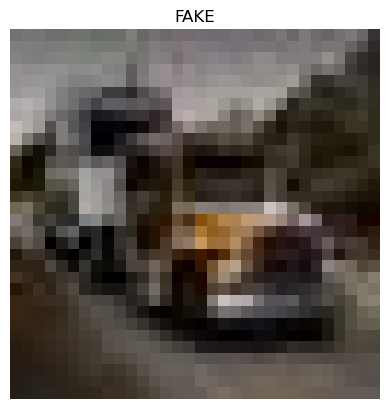

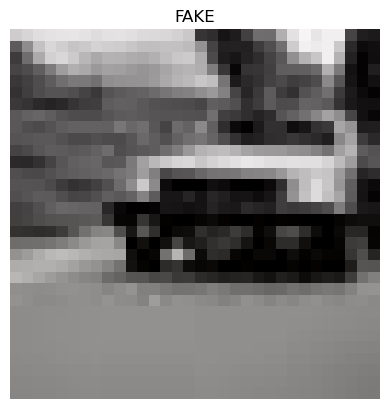

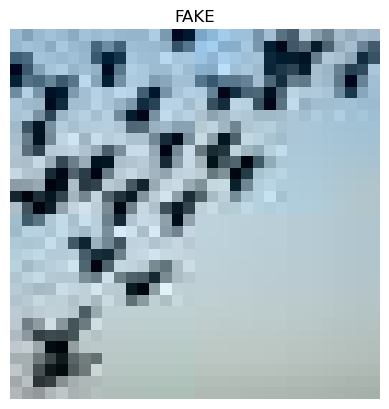

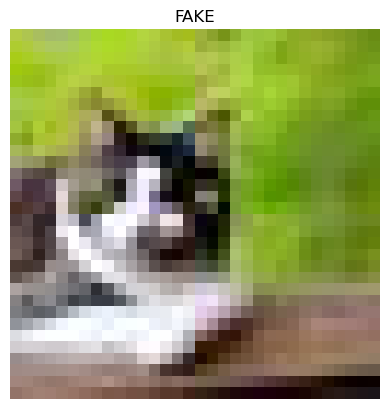

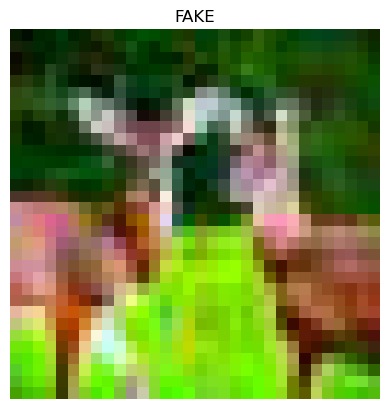

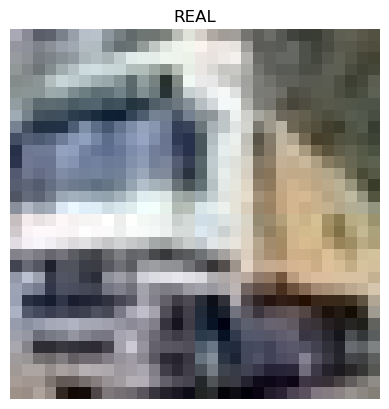

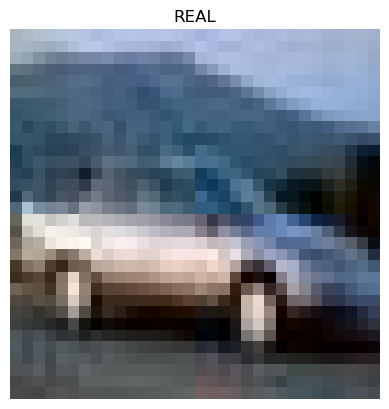

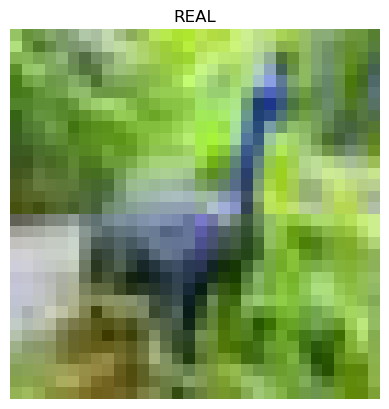

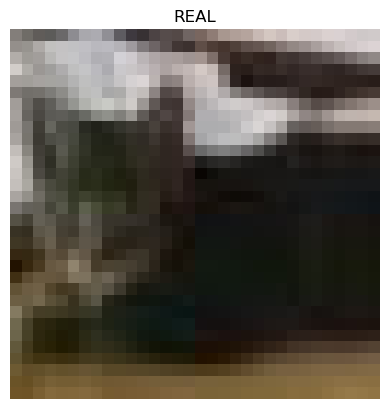

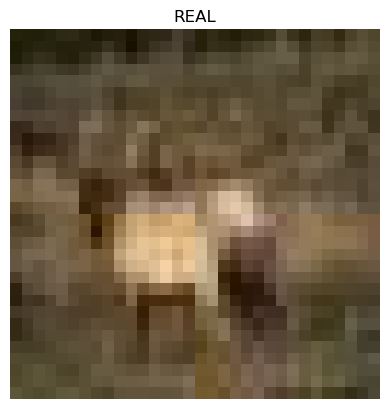

In [3]:
# Function to visualize sample images
def visualize_samples(directory, num_samples=5):
    classes = os.listdir(directory)
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        img_files = os.listdir(cls_dir)[:num_samples]
        for img_file in img_files:
            img_path = os.path.join(cls_dir, img_file)
            img = plt.imread(img_path)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
            plt.show()

visualize_samples(train_dataset_dir)


# data ogmentation

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator for the training set
train_generator = train_datagen.flow_from_directory(
    train_dataset_dir,
    target_size=(224, 224),  # Resize images to fit model input size
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (real vs. fake)
)


Found 100000 images belonging to 2 classes.


In [5]:
# Data generator for the validation set (without data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset_dir,  # Assuming you've defined test_dataset_dir earlier
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from datetime import datetime

# Data directories
train_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\train"
test_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"

# Number of epochs to run today
total_epochs = 20  # Increase the total number of epochs

# Calculate total number of images in training dataset
total_training_images = sum([len(files) for r, d, files in os.walk(train_dataset_dir)])

# Define the filepath for the checkpoint files
checkpoint_path = "training_checkpoint_epoch_{epoch:02d}_accuracy_{val_accuracy:.2f}.h5"

# Check for existing checkpoint files
if os.path.exists(checkpoint_path.format(epoch=1, val_accuracy=0.0)):
    print("Existing checkpoint found!")
    # Extract the epoch number from the last checkpoint file name
    checkpoint_files = os.listdir('.')
    last_checkpoint_epoch = max([int(file.split('_')[-3]) for file in checkpoint_files if 'training_checkpoint_epoch' in file])
    initial_epoch = last_checkpoint_epoch
    print("Resuming training from epoch:", initial_epoch)
else:
    print("No existing checkpoint found. Starting training from scratch.")
    initial_epoch = 0

# Image height and width
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Data preprocessing and augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load train and test datasets using TensorFlow Data API
train_generator = train_datagen.flow_from_directory(
    train_dataset_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dataset_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    class_mode='binary'
)

# Define the CNN architecture with improved features
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Added dropout layer for regularization
    Dense(256, activation='relu'),  # Adding more neurons to the dense layer
    Dropout(0.3),  # Added another dropout layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define checkpoint callback with custom naming
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=False,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      verbose=1,
                                      save_freq='epoch')  # Save frequency set to 'epoch'

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
if initial_epoch > 0:
    print("Loading existing checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path.format(epoch=initial_epoch, val_accuracy=0.0))
else:
    print("No existing checkpoint found. Starting training from scratch.")

# Calculate steps per epoch
steps_per_epoch = total_training_images // 32  # Batch size is 32

epochs_remaining = total_epochs - initial_epoch
if epochs_remaining > 0:
    print("Training remaining epochs:", epochs_remaining)
    history = model.fit(
        train_generator,
        epochs=total_epochs,
        initial_epoch=initial_epoch,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_generator,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                   checkpoint_callback,
                   lr_scheduler,
                   tensorboard_callback]
    )
else:
    print("All epochs already completed!")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Save the final trained model
model.save('final_model.h5')


In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Save the final trained model
model.save('final_model.h5')

# Print the total number of augmented images
print("Total number of augmented images:", total_augmented_images)


625/625 [==============================] - 58s 92ms/step - loss: 0.1542 - accuracy: 0.9358
Test accuracy: 0.9358000159263611
Total number of augmented images: 0


In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generator for the new data
new_data_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"
new_data_generator = ImageDataGenerator(rescale=1./255)

# Load the new data using the data generator
new_data = new_data_generator.flow_from_directory(
    new_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle the data, to keep track of filenames and predictions
)

# Load the trained model
model = tf.keras.models.load_model('trained_model.h5')

# Make predictions using the trained model
predictions = model.predict(new_data)

# Assuming you want to print the filenames and corresponding predictions
for filename, prediction in zip(new_data.filenames, predictions):
    print(filename, prediction)


Found 20000 images belonging to 2 classes.
625/625 [==============================] - 152s 243ms/step
FAKE\0 (10).jpg [0.15691541]
FAKE\0 (2).jpg [0.00651343]
FAKE\0 (3).jpg [0.34100664]
FAKE\0 (4).jpg [0.07389267]
FAKE\0 (5).jpg [0.02639448]
FAKE\0 (6).jpg [0.06171694]
FAKE\0 (7).jpg [0.00095241]
FAKE\0 (8).jpg [0.9553653]
FAKE\0 (9).jpg [0.87300175]
FAKE\0.jpg [0.04761373]
FAKE\1 (10).jpg [0.19691214]
FAKE\1 (2).jpg [0.6983947]
FAKE\1 (3).jpg [0.18440488]
FAKE\1 (4).jpg [0.28489685]
FAKE\1 (5).jpg [0.19716318]
FAKE\1 (6).jpg [0.17771743]
FAKE\1 (7).jpg [0.21161488]
FAKE\1 (8).jpg [0.09534243]
FAKE\1 (9).jpg [0.20270647]
FAKE\1.jpg [0.16789806]
FAKE\10 (10).jpg [0.16651247]
FAKE\10 (2).jpg [0.00778287]
FAKE\10 (3).jpg [0.10440342]
FAKE\10 (4).jpg [0.10365245]
FAKE\10 (5).jpg [0.01976889]
FAKE\10 (6).jpg [0.00449448]
FAKE\10 (7).jpg [0.00104262]
FAKE\10 (8).jpg [0.10890131]
FAKE\10 (9).jpg [0.1323138]
FAKE\10.jpg [0.04624569]
FAKE\100 (10).jpg [0.00071654]
FAKE\100 (2).jpg [0.00140948]

In [9]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

# Define the directories for the test dataset
test_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"

# Define the image dimensions
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dataset_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    class_mode='binary'
)

# Load the trained model
model = tf.keras.models.load_model("trained_model.h5")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test Accuracy:', test_accuracy)

# Save the trained model
model.save('trained_model.h5')


Found 20000 images belonging to 2 classes.
625/625 [==============================] - 58s 92ms/step - loss: 0.1542 - accuracy: 0.9358
Test Accuracy: 0.9358000159263611


Found 100000 images belonging to 2 classes.


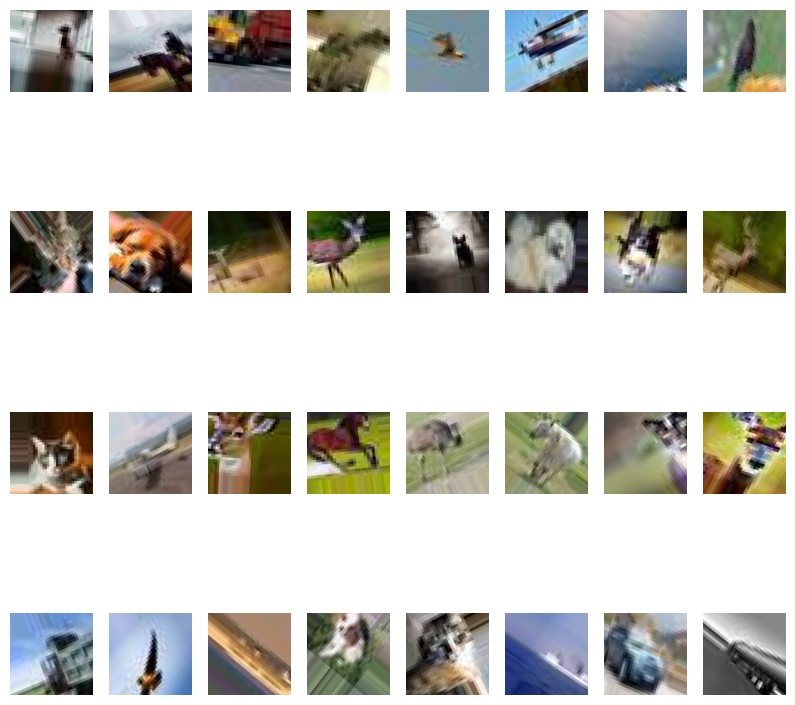

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data directories
train_data_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\train"
test_data_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"

# Image dimensions
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32

# Create a data generator with augmentation for visualization
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load a batch of augmented images
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Visualize a batch of augmented images
augmented_images, labels = next(train_generator)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(len(augmented_images)):
    plt.subplot(4, 8, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


# avove CNN got less test acuracy

# this is new

In [10]:
# import os
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Import ModelCheckpoint

# # Check if TensorFlow detects GPU
# print("Available GPUs:")
# print(tf.config.list_physical_devices('GPU'))

# # Data directories
# train_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\train"
# test_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"

# # Number of epochs to run today
# total_epochs = 16  # Total number of epochs you intend to train for

# # Checkpoint path
# checkpoint_path = "training_checkpoint.h5"

# # Check for existing checkpoint files
# if os.path.exists(checkpoint_path):
#     print("Existing checkpoint found!")

# # Image height and width
# IMAGE_HEIGHT = 128
# IMAGE_WIDTH = 128

# # Data preprocessing and augmentation
# def load_and_preprocess_image(path, label):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
#     image /= 255.0  # Normalize to [0,1]
#     return image, label

# # Load train and test datasets using TensorFlow Data API
# train_ds = tf.data.Dataset.list_files(train_dataset_dir + '/*/*')
# train_ds = train_ds.map(lambda x: load_and_preprocess_image(x, 0 if tf.strings.regex_full_match(x, '.*cat.*') else 1))

# test_ds = tf.data.Dataset.list_files(test_dataset_dir + '/*/*')
# test_ds = test_ds.map(lambda x: load_and_preprocess_image(x, 0 if tf.strings.regex_full_match(x, '.*cat.*') else 1))

# # Batch the datasets
# batch_size = 32
# train_ds = train_ds.batch(batch_size)
# test_ds = test_ds.batch(batch_size)

# # Define the CNN architecture with improved features
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),  # Added dropout layer for regularization
#     Dense(256, activation='relu'),  # Adding more neurons to the dense layer
#     Dropout(0.3),  # Added another dropout layer
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Define checkpoint callback
# checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
#                                       save_weights_only=False,
#                                       save_best_only=True,
#                                       monitor='val_loss',
#                                       verbose=1)

# # Train the model for the remaining epochs
# if os.path.exists(checkpoint_path):
#     print("Loading existing checkpoint...")
#     model = tf.keras.models.load_model(checkpoint_path)
#     initial_epoch = int(model.optimizer.iterations / len(train_ds))  # Calculate the epoch based on iterations
#     print("Resuming training from epoch:", initial_epoch)
# else:
#     print("No existing checkpoint found. Starting training from scratch.")
#     initial_epoch = 0

# epochs_remaining = total_epochs - initial_epoch
# if epochs_remaining > 0:
#     print("Training remaining epochs:", epochs_remaining)
#     history = model.fit(train_ds,
#                         epochs=total_epochs,
#                         initial_epoch=initial_epoch,
#                         validation_data=test_ds,
#                         callbacks=[EarlyStopping(patience=3, restore_best_weights=True), checkpoint_callback])
# else:
#     print("All epochs already completed!")

# # Evaluate the model
# test_loss, test_acc = model.evaluate(test_ds)
# print('Test accuracy:', test_acc)

# # Save the final trained model
# model.save('final_model.h5')



# successfull with this try

In [11]:
# import os
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Define a variable to track the number of augmented images
# total_augmented_images = 0

# # Define a custom callback to count augmented images
# class AugmentationCounterCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         super(AugmentationCounterCallback, self).__init__()

#     def on_batch_end(self, batch, logs=None):
#         global total_augmented_images
#         total_augmented_images += 1

# # Check if TensorFlow detects GPU
# print("Available GPUs:")
# print(tf.config.list_physical_devices('GPU'))

# # Data directories
# train_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\train"
# test_dataset_dir = r"C:\Users\Ramsaheb Prasad\Desktop\Ai image detector\test"

# # Number of epochs to run today
# total_epochs = 20  # Increase the total number of epochs

# # Define the filepath for the checkpoint files
# checkpoint_path = "training_checkpoint_epoch_{epoch:02d}.h5"

# # Check for existing checkpoint files
# if os.path.exists(checkpoint_path.format(epoch=1)):
#     print("Existing checkpoint found!")
#     # Extract the epoch number from the last checkpoint file name
#     checkpoint_files = os.listdir('.')
#     last_checkpoint_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files if 'training_checkpoint_epoch' in file])
#     initial_epoch = last_checkpoint_epoch
#     print("Resuming training from epoch:", initial_epoch)
# else:
#     print("No existing checkpoint found. Starting training from scratch.")
#     initial_epoch = 0

# # Image height and width
# IMAGE_HEIGHT = 128
# IMAGE_WIDTH = 128

# # Data preprocessing and augmentation
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# # Load train and test datasets using TensorFlow Data API
# train_generator = train_datagen.flow_from_directory(
#     train_dataset_dir,
#     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=32,
#     class_mode='binary'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dataset_dir,
#     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=32,
#     class_mode='binary'
# )

# # Define the CNN architecture with improved features
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),  # Added dropout layer for regularization
#     Dense(256, activation='relu'),  # Adding more neurons to the dense layer
#     Dropout(0.3),  # Added another dropout layer
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Define checkpoint callback
# checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
#                                       save_weights_only=False,
#                                       save_best_only=True,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_freq='epoch')  # Save frequency set to 'epoch'

# # Define augmentation counter callback
# augmentation_counter_callback = AugmentationCounterCallback()

# # Train the model
# if initial_epoch > 0:
#     print("Loading existing checkpoint...")
#     model = tf.keras.models.load_model(checkpoint_path.format(epoch=initial_epoch))
# else:
#     print("No existing checkpoint found. Starting training from scratch.")

# epochs_remaining = total_epochs - initial_epoch
# if epochs_remaining > 0:
#     print("Training remaining epochs:", epochs_remaining)
#     history = model.fit(
#         train_generator,
#         epochs=total_epochs,
#         initial_epoch=initial_epoch,
#         validation_data=test_generator,
#         callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
#                    checkpoint_callback,
#                    augmentation_counter_callback]
#     )
# else:
#     print("All epochs already completed!")

# # Evaluate the model
# test_loss, test_acc = model.evaluate(test_generator)
# print('Test accuracy:', test_acc)

# # Save the final trained model
# model.save('final_model.h5')

# # Print the total number of augmented images
# print("Total number of augmented images:", total_augmented_images)